# Question 3

In [1]:
error.rate <- function(Y1, T1){
  if (nrow(Y1)!=nrow(T1)){
    stop('error.rate: size of true lables and predicted labels mismatch')
  }
  return (sum(T1!=Y1)/nrow(T1))
}

In [2]:
options(warn=-1)
library(h2o)
#If there is a proxy: proxy.old <- Sys.getenv('http_proxy'); Sys.setenv('http_proxy'='');
localH2O =  h2o.init(nthreads = -1, max_mem_size = '6g', ip = "127.0.0.1", port = 54321)

# Students: Use the "absolute" path to the datasets on your machine (important)
labeled.frame <- h2o.importFile(path = 'Task2C_labeled.csv' ,sep=',') 
unlabeled.frame <- h2o.importFile(path = 'Task2C_unlabeled.csv',sep=',') 
test.frame <- h2o.importFile(path = 'Task2C_test.csv',sep=',') 

labeled.frame[,1] <- as.factor(labeled.frame$label)
# remove rows with all NA
unlabeled.frame <- h2o.na_omit(unlabeled.frame)
unlabeled.frame[,1] <- NA
train.frame <- h2o.rbind(labeled.frame[,-1], unlabeled.frame[,-1])
test.frame[,1] <- as.factor(test.frame$label)


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit http://docs.h2o.ai

----------------------------------------------------------------------


Attaching package: 'h2o'

The following objects are masked from 'package:stats':

    cor, sd, var

The following objects are masked from 'package:base':

    %*%, %in%, &&, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc



 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         2 hours 53 minutes 
    H2O cluster timezone:       Australia/Sydney 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.26.0.2 
    H2O cluster version age:    2 months and 13 days  
    H2O cluster name:           H2O_started_from_R_user_sqa669 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   1.29 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          127.0.0.1 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Amazon S3, Algos, AutoML, Core V3, Core V4 
    R Version:                  R version 3.5.1 (2018-07-02) 

  |======================================================================| 100%
  |======================================================================| 100%

### Run autoencoder

In [4]:
options(warn=-1)
reconstruction.error <- matrix(NA, nrow = 25, ncol = 2)

for (k in seq(20,500,20)){
    
    NN.model= h2o.deeplearning(    
    x = 1:784, # select all pixels
    training_frame = train.frame, # specify the frame (imported file)    
    hidden = c(k), # number of layers and their units
    epochs = 100, # maximum number of epoches  
    activation = 'Tanh', # activation function 
    autoencoder = TRUE  # is it an autoencoder? Yes!
    )
    # record reconstruction error
    reconstruction.error[k/20,1] <- k
    reconstruction.error[k/20,2] <- mean(h2o.anomaly(NN.model, train.frame))
    
}

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

In [5]:
# change to dataframe
reconstruction.error <- data.frame(reconstruction.error)
names(reconstruction.error) <- c('k','reconstruction_error')
head(reconstruction.error)

k,reconstruction_error
20,0.028033085
40,0.012858298
60,0.006499993
80,0.002936923
100,0.001522299
120,0.001274308


In [6]:
# minimum value of reconstruction error
reconstruction.error[which.min(reconstruction.error[,2]),]

,k,reconstruction_error
7,140,0.001184635


Saving 6.67 x 6.67 in image


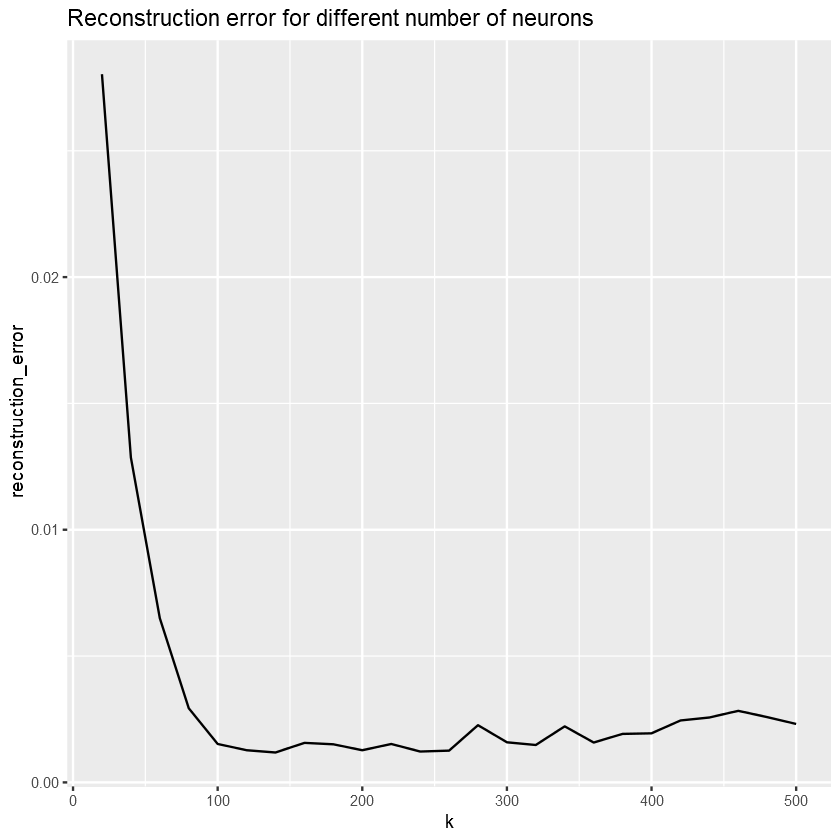

In [7]:
library(ggplot2)

ggplot(reconstruction.error , aes(k, reconstruction_error)) + 
geom_line()+
ggtitle('Reconstruction error for different number of neurons')
ggsave('Q3_1.jpg')

### Neural network

In [8]:
# build a neural network classifier based on the labeled training data
NN.model <- h2o.deeplearning(    
  x = 2:ncol(labeled.frame), # select all pixels + extra features
  y = 1,
  training_frame = labeled.frame, # specify the frame (imported file)    
  hidden = c(100), # number of layers and their units
  epochs = 50, # maximum number of epoches  
  activation = 'Tanh', # activation function 
  autoencoder = FALSE, # is it an autoencoder? Yes!
  l2 = 0.1
)

test.predict <- h2o.predict(NN.model, test.frame)$predict
error.rate(test.frame$label, test.predict)

  |======================================================================| 100%
  |======================================================================| 100%


[1] 0.539

The test error is 53.9%.

### Augmented self-taught network

In [24]:
# initialize dataframe to store result
test.error <- data.frame(matrix(NA,nrow = 25, ncol = 2))
names(test.error) <- c('extra_features','test_error')
head(test.error)

extra_features,test_error
NA,NA
NA,NA
NA,NA
NA,NA
NA,NA
NA,NA


In [25]:
dim(labeled.frame)

[1]  50 785

In [26]:
for (k in seq(20,500,20)){
    
    # train autoencoder
    NN.model= h2o.deeplearning(    
    x = 1:784, # select all pixels
    training_frame = train.frame, # specify the frame (imported file)    
    hidden = c(k), # number of layers and their units
    epochs = 100, # maximum number of epoches  
    activation = 'Tanh', # activation function 
    autoencoder = TRUE  # is it an autoencoder? Yes!
    )
    
    # get features
    features = h2o.deepfeatures(NN.model, labeled.frame, layer=1)
    # combine original features with trained features
    train_aug <- h2o.cbind(labeled.frame, features)
    
    # fit all features into neural network
    NN1.model <- h2o.deeplearning(    
          x = 2:ncol(train_aug), # select all pixels + extra features
          y = 1,
          training_frame = train_aug, # specify the frame (imported file)    
          hidden = c(100), # number of layers and their units
          epochs = 50, # maximum number of epoches  
          activation = 'Tanh', # activation function 
          autoencoder = FALSE, # is it an autoencoder? Yes!
          l2 = 0.1
          )
    
    test.predict <- h2o.predict(NN1.model, test.frame)$predict
    test.error[k/20, 1] <- k
    test.error[k/20, 2] <- error.rate(test.frame$label, test.predict)
}

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

In [27]:
test.error

extra_features,test_error
20,0.615
40,0.596
60,0.557
80,0.607
100,0.597
120,0.569
140,0.585
160,0.525
180,0.551
200,0.570


In [30]:
test.error[which.min(test.error[,2]),]

,extra_features,test_error
20,400,0.481


Saving 6.67 x 6.67 in image


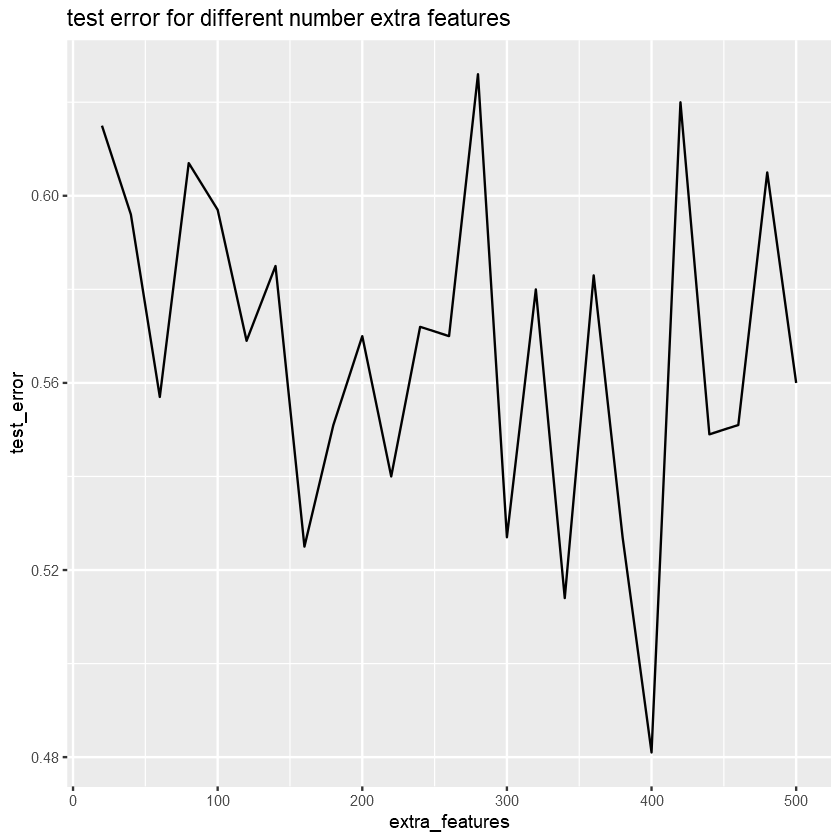

In [28]:
ggplot(test.error , aes(extra_features, test_error)) + 
geom_line()+
ggtitle('test error for different number extra features')
ggsave('Q3_2.jpg')